<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>

# Clustering with scikit-learn

<br><br></p>

En este cuaderno, aprenderemos cómo realizar K-Means usando scikit-learn en Python.

Utilizaremos el análisis de conglomerados para generar un modelo del clima  utilizando datos con definición de minuto. Este conjunto de datos tiene millones de registros. ¿Cómo creamos 12 grupos?

NOTA: El conjunto de datos que usaremos está en un archivo CSV grande llamado minuto.csv. 

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Importando librerías<br></p>

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import datetime

%matplotlib inline

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Creando un Pandas DataFrame desde un archivo CSV<br><br></p>


In [2]:
data = pd.read_csv('./meteo/minuto.csv')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Datos meteorológicos por minuto</p>
<br>
El conjunto de datos meteorológicos de ** minutos ** proviene de la misma fuente que el conjunto de datos meteorológicos diarios que usamos en el cuaderno clasificador basado en el árbol de decisión. La principal diferencia entre estos dos conjuntos de datos es que el conjunto de datos meteorológicos por minuto contiene mediciones de sensores sin procesar capturadas en intervalos de un minuto. El conjunto de datos meteorológicos diarios en su lugar contenía datos procesados (promedios).

Al igual que con los datos meteorológicos diarios, estos datos provienen de una estación meteorológica. La estación meteorológica está equipada con sensores que capturan mediciones relacionadas con el clima, como la temperatura del aire, la presión del aire y la humedad relativa. Los datos se recopilaron durante un período de tres años, de septiembre de 2011 a septiembre de 2014, para garantizar que se capturan datos suficientes para diferentes estaciones y condiciones climáticas.

Cada fila en ** minuto.csv ** contiene datos meteorológicos capturados para un intervalo de un minuto. Cada fila, o muestra, consta de las siguientes variables:

* **rowID:** 	Llave única
* **hpwren_timestamp:**	timestamp de la medida	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** presión atmosférica	(*Hectopascales*)
* **air_temp:**	Temperatura del aire	(*Grados Fahrenheit*)
* **avg_wind_direction:**	direccion del viento promedio durante el minuto previo al timestamp
* **avg_wind_speed:**	velocidad del viento promedio durante el minuto previo al timestamp (metros por segundo)
* **max_wind_direction:**	Direccion máxima del viento 
* **max_wind_speed:**	Velocidad máxima del viento
* **min_wind_direction:**	Dirección mínima del viento
* **min_wind_speed:**	Velocidad mínima del viento
* **rain_accumulation:**	Acumulación de lluvia al timestamp
* **rain_duration:**	duración de la lluvia
* **relative_humidity:**	humedad relativa medida en el timestamp

In [3]:
data.shape

(1587257, 13)

In [4]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Data Sampling<br></p>

Tenemos demasiadas filas en el dataset, bajaremos la cantidad a un 10% <br>


In [5]:
# Elijo una de cada 10 filas, para esto elijo cada fila que dividido 10 tiene resto 0
sampled_df = data[(data['rowID'] % 10) == 0] 
sampled_df.shape

(158726, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Estadisticas
<br><br></p>


In [6]:
# Describo la muestra, paso columnas a filas y filas a columnas para que la descripion luzca mejor
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937510,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [7]:
# Detectamos que las columnas rain accumulation y rain duration tienen valores en cero
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [8]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Limpiando datos
<br><br></p>


In [9]:
# Como estas dos columnas tienen muchisimos ceros directamente las borramos enteras
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [10]:
rows_before = sampled_df.shape[0]
# Borramos filas que contengan algun valor nulo
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Cuántas filas perdimos ?
<br><br></p>


In [11]:
rows_before - rows_after

46

In [12]:
sampled_df.columns # Corroboramos qué columnas quedaron

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Seleccionamos las cualidades de interés para encarar el clustering
<br><br></p>


In [14]:
# Estás son las columnas que seleccionamos como features
features = [
    'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
    'max_wind_direction', 'max_wind_speed','relative_humidity'
]

In [15]:
# Filtro el contenido dejando solo las columnas seleccionadas
select_df = sampled_df[features]

In [16]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [17]:
select_df

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4
...,...,...,...,...,...,...,...
1587210,915.9,75.56,330.0,1.0,341.0,1.3,47.8
1587220,915.9,75.56,330.0,1.1,341.0,1.4,48.0
1587230,915.9,75.56,344.0,1.4,352.0,1.7,48.0
1587240,915.9,75.20,359.0,1.3,9.0,1.6,46.3


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Scale the Features using StandardScaler
<br><br></p>


In [18]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Implementando k-Means Clustering
<br><br></p>


In [21]:
# Seteo la cantidad de clusters que quiero generar
kmeans = KMeans(n_clusters=12)
# Ajustamos el modelo
model = kmeans.fit(X)
print(f'model: {model}')

model: KMeans(n_clusters=12)


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>


¿Cuáles son los centros de los 12 grupos que formamos?
<br><br></p>


In [22]:
centers = model.cluster_centers_
centers

array([[ 0.75387735,  0.40074005,  0.29161598, -0.5279575 ,  0.478849  ,
        -0.53383464, -0.76527158],
       [-0.84136013, -1.20081464,  0.37635877,  0.39421054,  0.47459201,
         0.38169601,  1.35711886],
       [-0.16555067,  0.8650509 , -1.31006536, -0.58988424, -1.16577596,
        -0.60517512, -0.64050133],
       [-0.68340205,  0.56375636,  0.18043616, -0.58587237,  0.35043621,
        -0.59913945, -0.12992186],
       [ 1.19064415, -0.25421775, -1.15483729,  2.11886894, -1.05318976,
         2.2356129 , -1.13457317],
       [ 0.05627706, -0.786888  , -1.19575941, -0.57091503, -1.04175554,
        -0.58552652,  0.87860184],
       [ 0.13116065,  0.84358593,  1.41125827, -0.6386429 ,  1.67556746,
        -0.58948616, -0.71315535],
       [ 0.21415099, -0.99869599,  0.65016816, -0.54632062,  0.83889022,
        -0.52951392,  1.17408879],
       [-0.21304828,  0.63495794,  0.40853626,  0.73406098,  0.51666921,
         0.67211362, -0.15111861],
       [ 0.23399236,  0.3200

<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>

Plots
<br><br></p>



Primero creamos algunas funciones útiles que nos ayudarán a trazar gráficos:

In [23]:
def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')


	Z = [np.append(A, index) for index, A in enumerate(centers)]

	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [26]:
# Funcion para crear gráficos paralelos

def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [27]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.753877,0.400740,0.291616,-0.527957,0.478849,-0.533835,-0.765272,0
1,-0.841360,-1.200815,0.376359,0.394211,0.474592,0.381696,1.357119,1
2,-0.165551,0.865051,-1.310065,-0.589884,-1.165776,-0.605175,-0.640501,2
3,-0.683402,0.563756,0.180436,-0.585872,0.350436,-0.599139,-0.129922,3
4,1.190644,-0.254218,-1.154837,2.118869,-1.053190,2.235613,-1.134573,4
5,0.056277,-0.786888,-1.195759,-0.570915,-1.041756,-0.585527,0.878602,5
6,0.131161,0.843586,1.411258,-0.638643,1.675567,-0.589486,-0.713155,6
7,0.214151,-0.998696,0.650168,-0.546321,0.838890,-0.529514,1.174089,7
8,-0.213048,0.634958,0.408536,0.734061,0.516669,0.672114,-0.151119,8
9,0.233992,0.320021,1.887919,-0.651769,-1.551747,-0.576601,-0.283582,9


# Dry Days

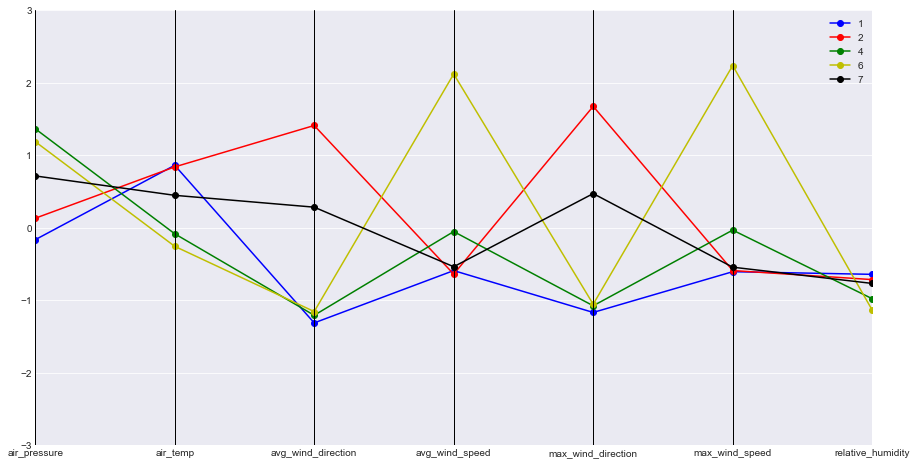

In [22]:
parallel_plot(P[P['relative_humidity'] < -0.5])

# Warm Days

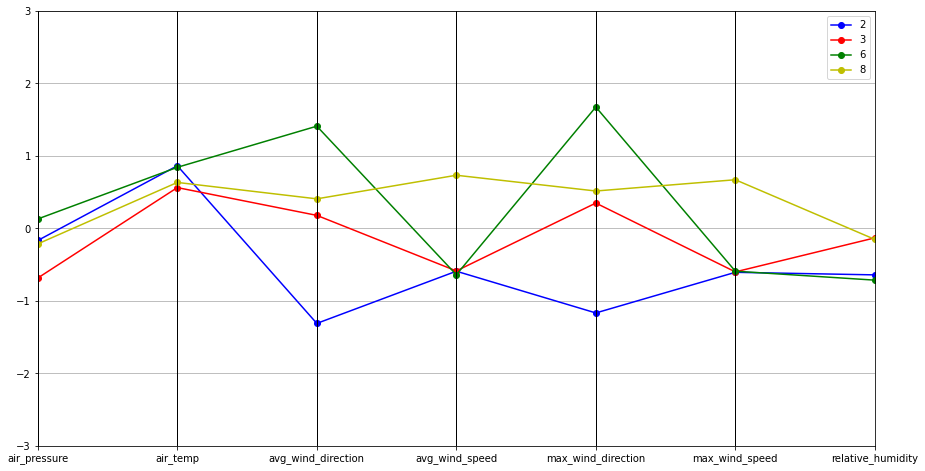

In [29]:
parallel_plot(P[P['air_temp'] > 0.5])

# Cool Days

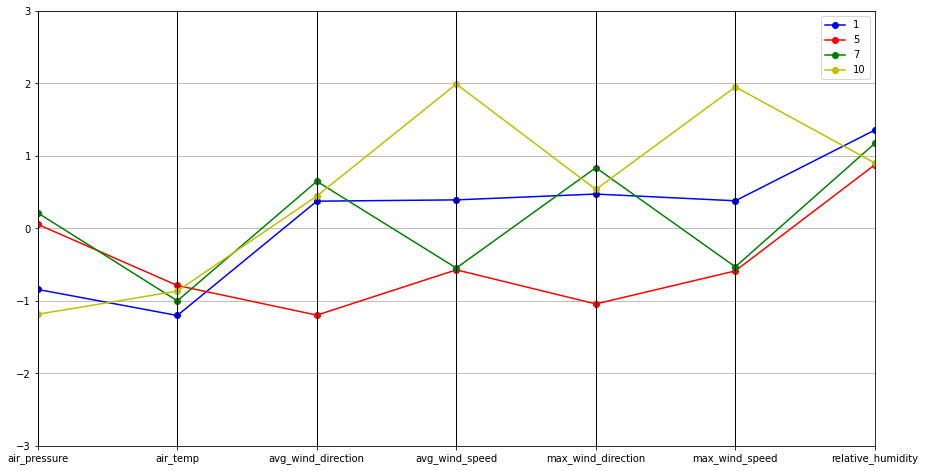

In [30]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])